In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#https://www.data4v.com/tutorial-hierarchical-clustering-in-spark-with-bisecting-k-means/

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
spark = SparkSession.builder \
    .appName('bisectingK') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [4]:
data_path = "/papers_2000/"

## Citation Table

In [5]:
def read_table(kws_source="kws", method="bkmeans"):
    df = pd.read_csv("../data/processed/papers_2000/"+kws_source+"/"+method+"_mean_table.csv")
    df = df[['prediction', 'mean', 'sigma', 'count']]
    df = df.sort_values("count", ignore_index=True)
    df["kws_source"] = kws_source
    df["method"] = method
    return df.reset_index()

In [6]:
df_table = pd.DataFrame()
for method in ["kmeans", "bkmeans"]:
    for kws_source in ["kws", "abs"]:
        df_table = pd.concat([df_table, read_table(kws_source=kws_source, method=method)])

In [8]:
read_table("kws", "kmeans")

,index,prediction,mean,sigma,count,kws_source,method
0,0,1,3838.500000,337.289935,2,kws,kmeans
1,1,2,1436.600000,350.284075,10,kws,kmeans
2,2,5,12.761905,41.857953,42,kws,kmeans
3,3,3,681.627451,143.651239,51,kws,kmeans
4,4,4,48.619048,59.144279,105,kws,kmeans
5,5,6,308.595238,82.734279,168,kws,kmeans
6,6,7,104.820312,38.644925,896,kws,kmeans
7,7,0,13.599830,15.051297,4698,kws,kmeans


In [37]:
tab = round(df_table.query("kws_source == 'kws' & method == 'bkmeans'")[["count", "mean", "sigma"]])
tab

,count,mean,sigma
0,1,4077.0,NaN
1,3,2561.0,925.0
2,21,1044.0,214.0
3,43,13.0,41.0
4,77,522.0,102.0
5,670,155.0,69.0
6,1689,40.0,24.0
7,3468,8.0,9.0


In [ ]:
ss

In [36]:
print(tab.to_latex(index=False).replace(".0",""))

\begin{tabular}{rrr}
\toprule
 count &   mean &  sigma \\
\midrule
     1 & 4077 &    NaN \\
     3 & 2561 &  925 \\
    21 & 1044 &  214 \\
    43 &   13 &   41 \\
    77 &  522 &  102 \\
   670 &  155 &   69 \\
  1689 &   40 &   24 \\
  3468 &    8 &    9 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_85050/1961828331.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab.to_latex(index=False).replace(".0",""))


In [8]:
df_table.pivot(values = "count", index = "index", columns = ["method", "kws_source"])

method     kmeans       bkmeans      
kws_source    kws   abs     kws   abs
index                                
0               2     2       1     3
1              10     3       3     8
2              42     7      21    28
3              51    18      43    65
4             105    76      77   176
5             168   273     670   481
6             896  1088    1689  1386
7            4698  3836    3468  3156

In [94]:
kws_bkmeans.filter("prediction == 7")

CP__violation,Feynman_graph,Feynman_graph__higher-order,Higgs_particle__mass,None,_corrupt_record,bibliography,citation_count,critical_phenomena,effective_Lagrangian,electron_positron__annihilation,electroweak_interaction,features,id,neutrino__cosmic_radiation,neutrino__mass,neutrino__mixing_angle,neutrino__oscillation,neutrino__solar,num_refs,number_of_pages,numerical_calculations,numerical_calculations__interpretation_of_experiments,p_p__inclusive_reaction,perturbation_theory__higher-order,prediction,quantum_chromodynamics,supersymmetry,title
0,0,0,0,0,null,1,4077,0,0,0,0,"{[5, 6, 16, 17], ...",1861,0,0,0,0,0,766,878,0,0,0,0,7,0,0,Review of particl...


In [9]:
print(_.to_latex())

\begin{tabular}{lrrrr}
\toprule
method & \multicolumn{2}{l}{kmeans} & \multicolumn{2}{l}{bkmeans} \\
kws\_source &    kws &   abs &     kws &   abs \\
index &        &       &         &       \\
\midrule
0     &      2 &     2 &       1 &     3 \\
1     &     10 &     3 &       3 &     8 \\
2     &     42 &     7 &      21 &    28 \\
3     &     51 &    18 &      43 &    65 \\
4     &    105 &    76 &      77 &   176 \\
5     &    168 &   273 &     670 &   481 \\
6     &    896 &  1088 &    1689 &  1386 \\
7     &   4698 &  3836 &    3468 &  3156 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_80044/4103285451.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(_.to_latex())


In [10]:
df_table.pivot(values = "mean", index = "index", columns = ["method", "kws_source"]).astype(int)

method     kmeans       bkmeans      
kws_source    kws   abs     kws   abs
index                                
0            3838  3435    4077  3041
1            1436  1879    2561  1363
2              12    38    1043   766
3             681  1005      13   469
4              48   520     521   240
5             308   218     154   120
6             104    75      40    41
7              13    11       7     8

In [66]:
print(_.style.to_latex())

\begin{tabular}{lrrrr}
method & \multicolumn{2}{r}{kmeans} & \multicolumn{2}{r}{bkmeans} \\
kws_source & kws & abs & kws & abs \\
index &  &  &  &  \\
0 & 3838 & 3435 & 4077 & 3041 \\
1 & 1436 & 1879 & 2561 & 1363 \\
2 & 12 & 38 & 1043 & 766 \\
3 & 681 & 1005 & 13 & 469 \\
4 & 48 & 520 & 521 & 240 \\
5 & 308 & 218 & 154 & 120 \\
6 & 104 & 75 & 40 & 41 \\
7 & 13 & 11 & 7 & 8 \\
\end{tabular}



In [41]:
kws_kmeans = spark.read.json("../data/processed/papers_2000/kws/KMeans/")
kws_bkmeans = spark.read.json("../data/processed/papers_2000/kws/BKmeans/")

abs_kmeans = spark.read.json("../data/processed/papers_2000/abs/KMeans/")
abs_bkmeans = spark.read.json("../data/processed/papers_2000/abs/BKmeans/")

In [45]:
kws_kmeans.groupby("prediction").count().sort(asc("count"))

prediction,count
5,1
1,2
6,3
3,28
2,44
4,134
7,868
0,4892


In [ ]:
kws_kmeans.filter("

In [22]:
from pyspark.sql.functions import monotonically_increasing_id, lit

In [23]:
kws_kmeans_count = kws_kmeans.groupby("prediction").count().sort(desc("count")).withColumn("id", monotonically_increasing_id())
kws_bkmeans_count = kws_bkmeans.groupby("prediction").count().sort(desc("count")).withColumn("id", monotonically_increasing_id())

abs_kmeans_count = abs_kmeans.groupby("prediction").count().sort(desc("count")).withColumn("id", monotonically_increasing_id())
abs_bkmeans_count = abs_bkmeans.groupby("prediction").count().sort(desc("count")).withColumn("id", monotonically_increasing_id())


In [91]:
kws_bkmeans_count

prediction,count,id
0,3468,0
1,1689,1
2,670,2
null,414,3
4,77,4
3,43,5
5,21,6
6,3,7
7,1,8


In [24]:
kws_kmeans_count.join(kws_bkmeans_count, on="id").join(abs_kmeans_count, on="id").join(abs_bkmeans_count, on="id").drop("prediction").withColumn("id", col("id")+lit(1))

id,count,count,count,count
1,4892,3468,3927,3156
2,868,1689,1002,1386
3,134,670,237,481
4,44,414,72,176
5,28,77,52,65
6,3,43,9,28
7,2,21,3,8
8,1,3,1,3


Companies from most popular clusters in KMeans and BKmeans

In [15]:
kws_kmeans_count

prediction,count,id
0,4892,0
7,868,1
4,134,2
2,44,3
3,28,4
6,3,5
1,2,6
5,1,7


In [16]:
def get_nth_cluster(data, n):
    # number of n-th by popularuty cluster
    N = data.\
        groupby("prediction").count().sort(desc("count")).\
        collect()[n][0]
    # companies in this cluster
    ids = data.filter("prediction == " + str(N)).select("id").collect()
    return set([id_[0] for id_ in ids])

In [17]:
sim_list = []
for k in range(8):
    MP_kmeans = get_nth_cluster(abs_kmeans, k)
    MP_bkmeans = get_nth_cluster(kws_bkmeans, k)
    sim_list.append([k, 2*len(MP_kmeans.intersection(MP_bkmeans))/( len(MP_kmeans) + len(MP_bkmeans))])
sim_list = np.array(sim_list)

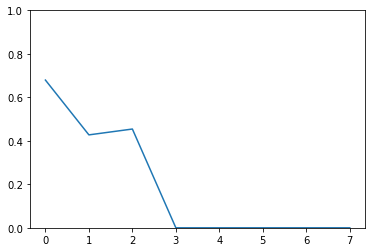

In [18]:
plt.plot(sim_list[:,0], sim_list[:,1])
plt.ylim(0,1);

In [34]:
kmeans = kws_kmeans
bkmeans = kws_bkmeans
numeric_columns = [c[0] for c in bkmeans.dtypes if c[1] == 'bigint']
len(numeric_columns)

26

In [30]:
import pyspark.sql.functions as F

What columns make the difference between clusters i1=0 and i1+1?

In [78]:
def get_means(col, data):
    means = bkmeans.select(col, "prediction").groupby("prediction").\
            agg(mean(col), F.count(F.lit(1)).alias("count")).\
            sort(desc("count"))
    return means

In [88]:
bkmeans.select(numeric_columns+["prediction"]).groupby("prediction").agg(mean(numeric_columns[0]))

prediction,avg(CP__violation)
0,0.08275663206459054
6,0.0
5,0.09523809523809523
1,0.1343990526939017
3,0.27906976744186046
2,0.10597014925373134
4,0.11688311688311688
7,0.0
null,null


In [90]:
bkmeans.filter("prediction == 0").count()

3468

In [84]:
get_means(numeric_columns[0], bkemans)

prediction,avg(CP__violation),count
0,0.08275663206459054,3468
1,0.1343990526939017,1689
2,0.10597014925373134,670
null,null,414
4,0.11688311688311688,77
3,0.27906976744186046,43
5,0.09523809523809523,21
6,0.0,3
7,0.0,1


In [73]:
i1, i2 = 1, 5
counts = pd.DataFrame()
for col in numeric_columns:
    means = bkmeans.select(col, "prediction").groupby("prediction").\
        agg(mean(col), F.count(F.lit(1)).alias("count")).\
        sort(desc("count")).collect()
    counts = pd.concat([counts, pd.DataFrame([{"i1":i1, "i2":i2, "col":col, "mean1":means[i1][1], "mean2":means[i2][1]}])])
counts["ratio"] = counts["mean1"]/counts["mean2"]

In [74]:
round(counts.sort_values("ratio", ascending=False), 3)

,i1,i2,col,mean1,mean2,ratio
0,1,5,perturbation_theory__higher-order,6.700000e-02,0.000000e+00,inf
0,1,5,neutrino__mixing_angle,8.300000e-02,0.000000e+00,inf
0,1,5,p_p__inclusive_reaction,5.400000e-02,0.000000e+00,inf
0,1,5,Higgs_particle__mass,6.100000e-02,0.000000e+00,inf
0,1,5,numerical_calculations,5.030000e-01,2.300000e-02,21.640
0,1,5,numerical_calculations__interpretation_of_expe...,2.130000e-01,2.300000e-02,9.165
0,1,5,Feynman_graph__higher-order,9.900000e-02,2.300000e-02,4.277
0,1,5,Feynman_graph,9.500000e-02,2.300000e-02,4.099
0,1,5,id,1.095484e+10,3.196256e+09,3.427
0,1,5,effective_Lagrangian,7.300000e-02,2.300000e-02,3.157


In [45]:
ratios = []
i1 = 0
i2 = 6
for col in numeric_columns:
    means = bkmeans.select(col, "prediction").groupby("prediction").\
        agg(mean(col), F.count(F.lit(1)).alias("count")).\
        sort(desc("count")).collect()
    ratios.append(means[i1][1]/means[i2][1] if means[i1+1][1] else 0)
ratios = np.array(ratios)

np.argsort(-ratios)

ZeroDivisionError: float division by zero

In [43]:
-np.sort(-ratios)

array([1.26827275, 1.13338408, 1.12106469, 1.11842971, 1.06799654,
       1.02453029, 0.99964476, 0.98017955, 0.94995482, 0.94010985,
       0.92783816, 0.91863762, 0.90058087, 0.89952385, 0.84808395,
       0.81030152, 0.79336886, 0.76857608, 0.74867202, 0.73442817,
       0.7293875 , 0.71681572, 0.67015627, 0.5       , 0.25862787,
       0.        ])

In [41]:
numeric_columns[9]

'electron_positron__annihilation'